In [1]:
import numpy as np
import anndata as ann
import pandas as pd
import scanpy as sc
import scvelo as scv
import scipy as sp
# import scipy as sci
import matplotlib.pyplot as pl
import matplotlib.pylab as pit
# import math
# import csv
# import loompy
import leidenalg
import bbknn
#pretty plotting
import seaborn as sb
import scrublet as scr

from IPython.core.display import display, HTML
from matplotlib import rcParams

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
sc.logging.print_versions()
scv.logging.print_version()

-----
anndata     0.7.3
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 7.0.0
anndata             0.7.3
annoy               NA
appnope             0.1.0
backcall            0.1.0
bbknn               NA
bottleneck          1.3.2
cffi                1.14.0
cloudpickle         1.3.0
colorama            0.4.3
cycler              0.10.0
cython_runtime      NA
cytoolz             0.10.1
dask                2.22.0
dateutil            2.8.1
decorator           4.4.1
get_version         2.1
google              NA
h5py                2.10.0
igraph              0.8.2
importlib_metadata  1.5.0
ipykernel           5.1.4
ipython_genutils    0.2.0
ipywidgets          7.5.1
jedi                0.14.1
joblib              0.14.1
kiwisolver          1.1.0
legacy_api_wrap     1.2
leidenalg           0.8.0
llvmlite            0.33.0
matplotlib          3.3.1
mpl_toolkits        NA
natsort             7.0.1
numba               0.50.1
numexpr             2.7.1
numpy               1.18.5
packagi

# Set project file paths

In [3]:
file_path = '/Users/Chiara/Documents/PhD/Project_primary_resistance/scRNAseq/10x_5_treatment_data_v3'

In [4]:
data_dir = file_path + '/data/' 
table_dir = file_path + '/tables/'
sc.settings.figdir = file_path + '/figures/'

In [5]:
adata=sc.read('/Users/Chiara/Documents/PhD/Project_primary_resistance/scRNAseq/10x_5_treatment_data_v3/Overall/data/Overlay_treatment_preprocessing_V04-sb.h5ad')

In [6]:
np.shape(adata)

(30677, 15769)

In [7]:
adata

AnnData object with n_obs × n_vars = 30677 × 15769
    obs: 'batch', 'batch_key', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'phase', 'S_score', 'G2M_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'log_total_counts', 'log_pct_counts_ribo', 'log_pct_counts_mito', 'leiden', 'annotated', 'annotated_1', 'annotated_2'
    var: 'feature_types', 'gene_ids-0', 'gene_ids-1', 'gene_ids-10', 'gene_ids-11', 'gene_ids-12', 'gene_ids-13', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'gene_ids-8', 'gene_ids-9', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ribo', 'n_counts', 'h

In [8]:
sc.settings.set_figure_params(dpi=120, dpi_save=300, vector_friendly=True, transparent=True, color_map='viridis')

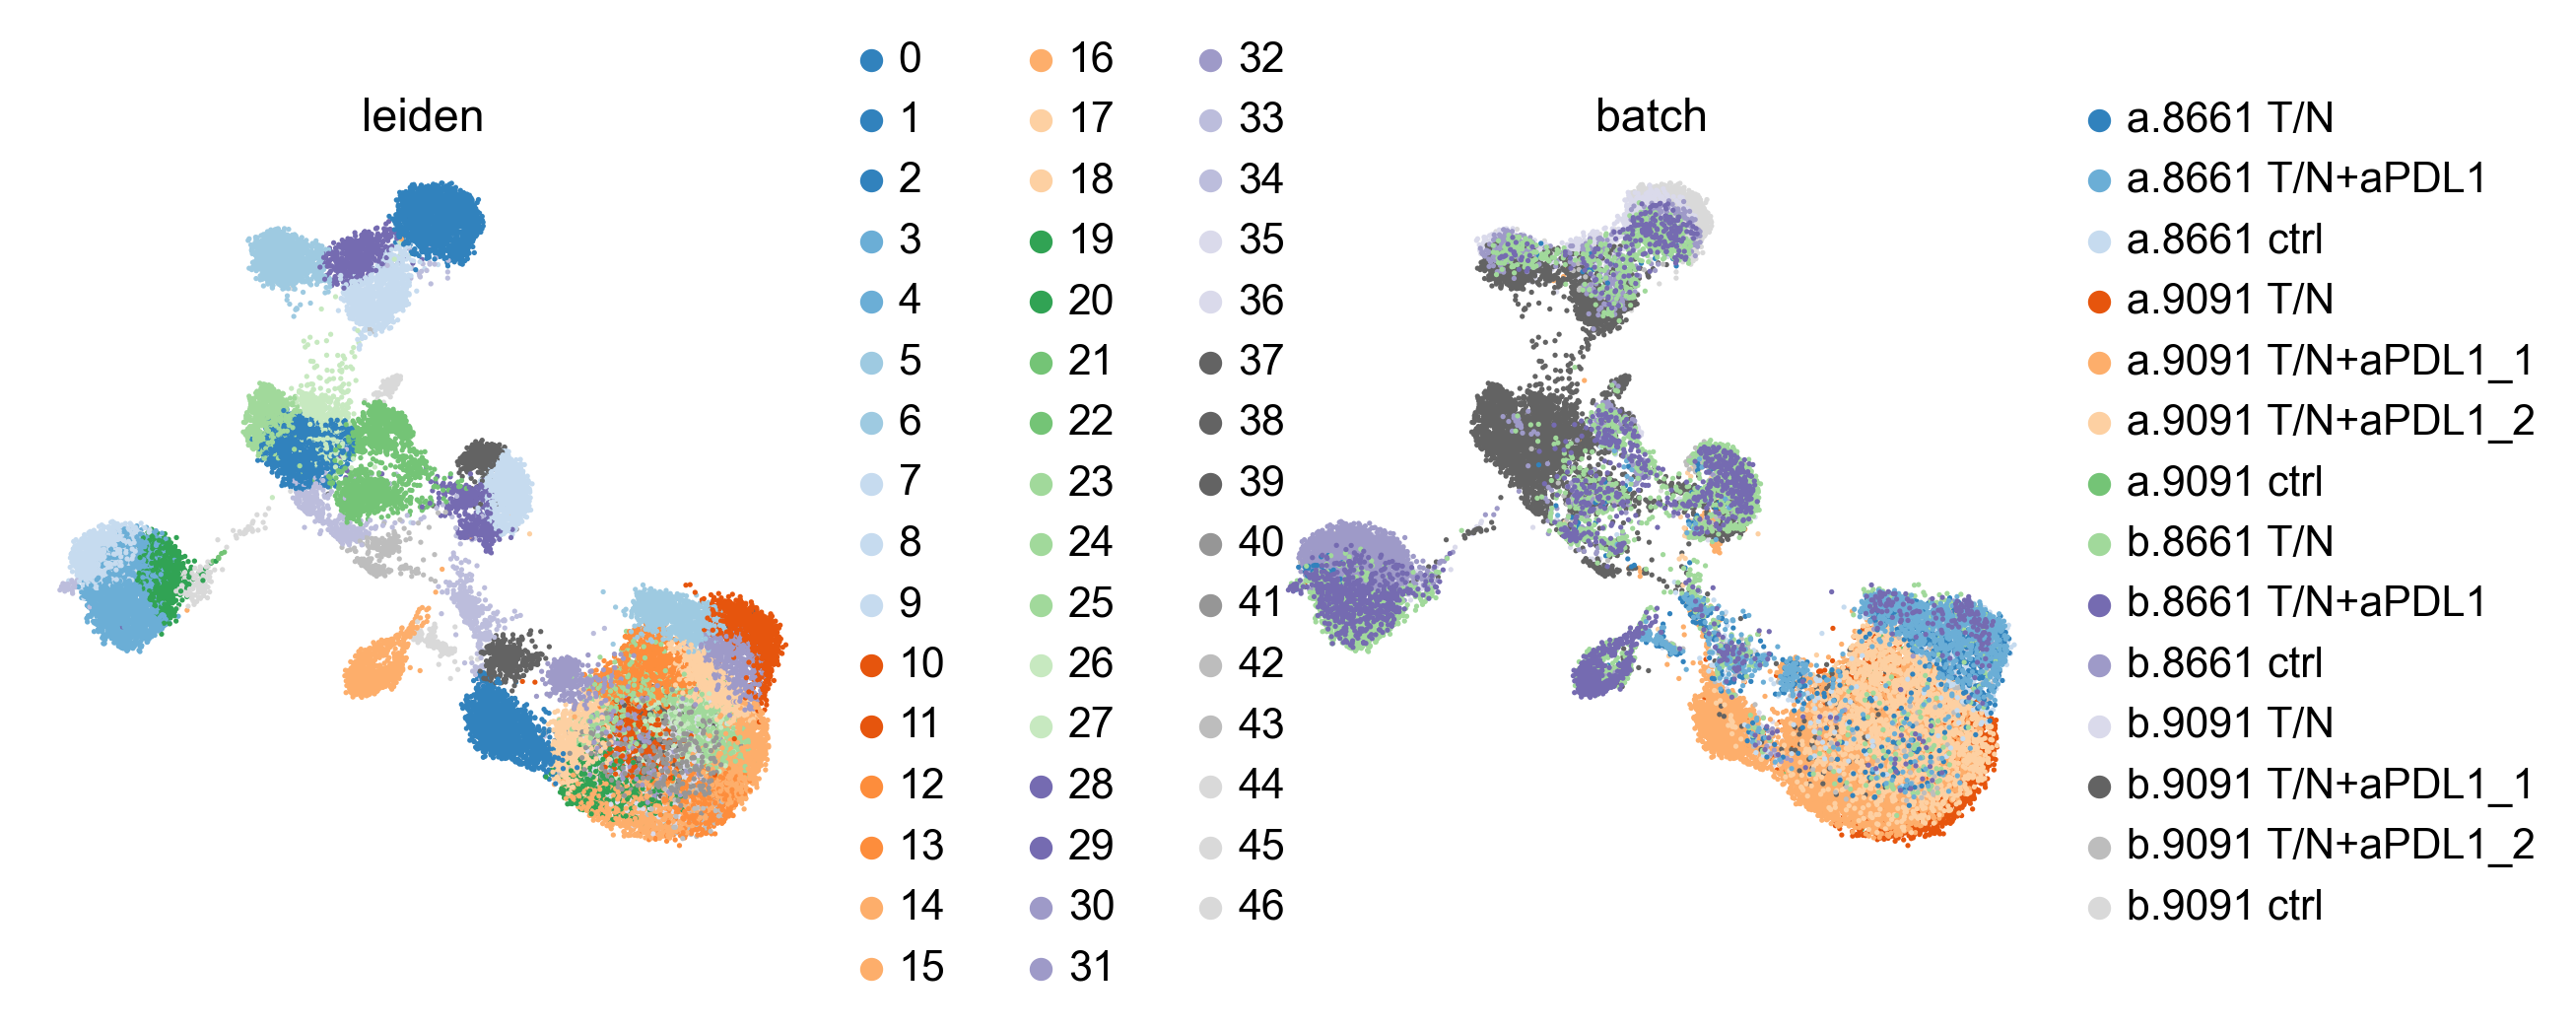

In [9]:
sc.pl.umap(adata, color=['leiden','batch'], size=10, wspace=0.4, palette='tab20c', frameon=False)

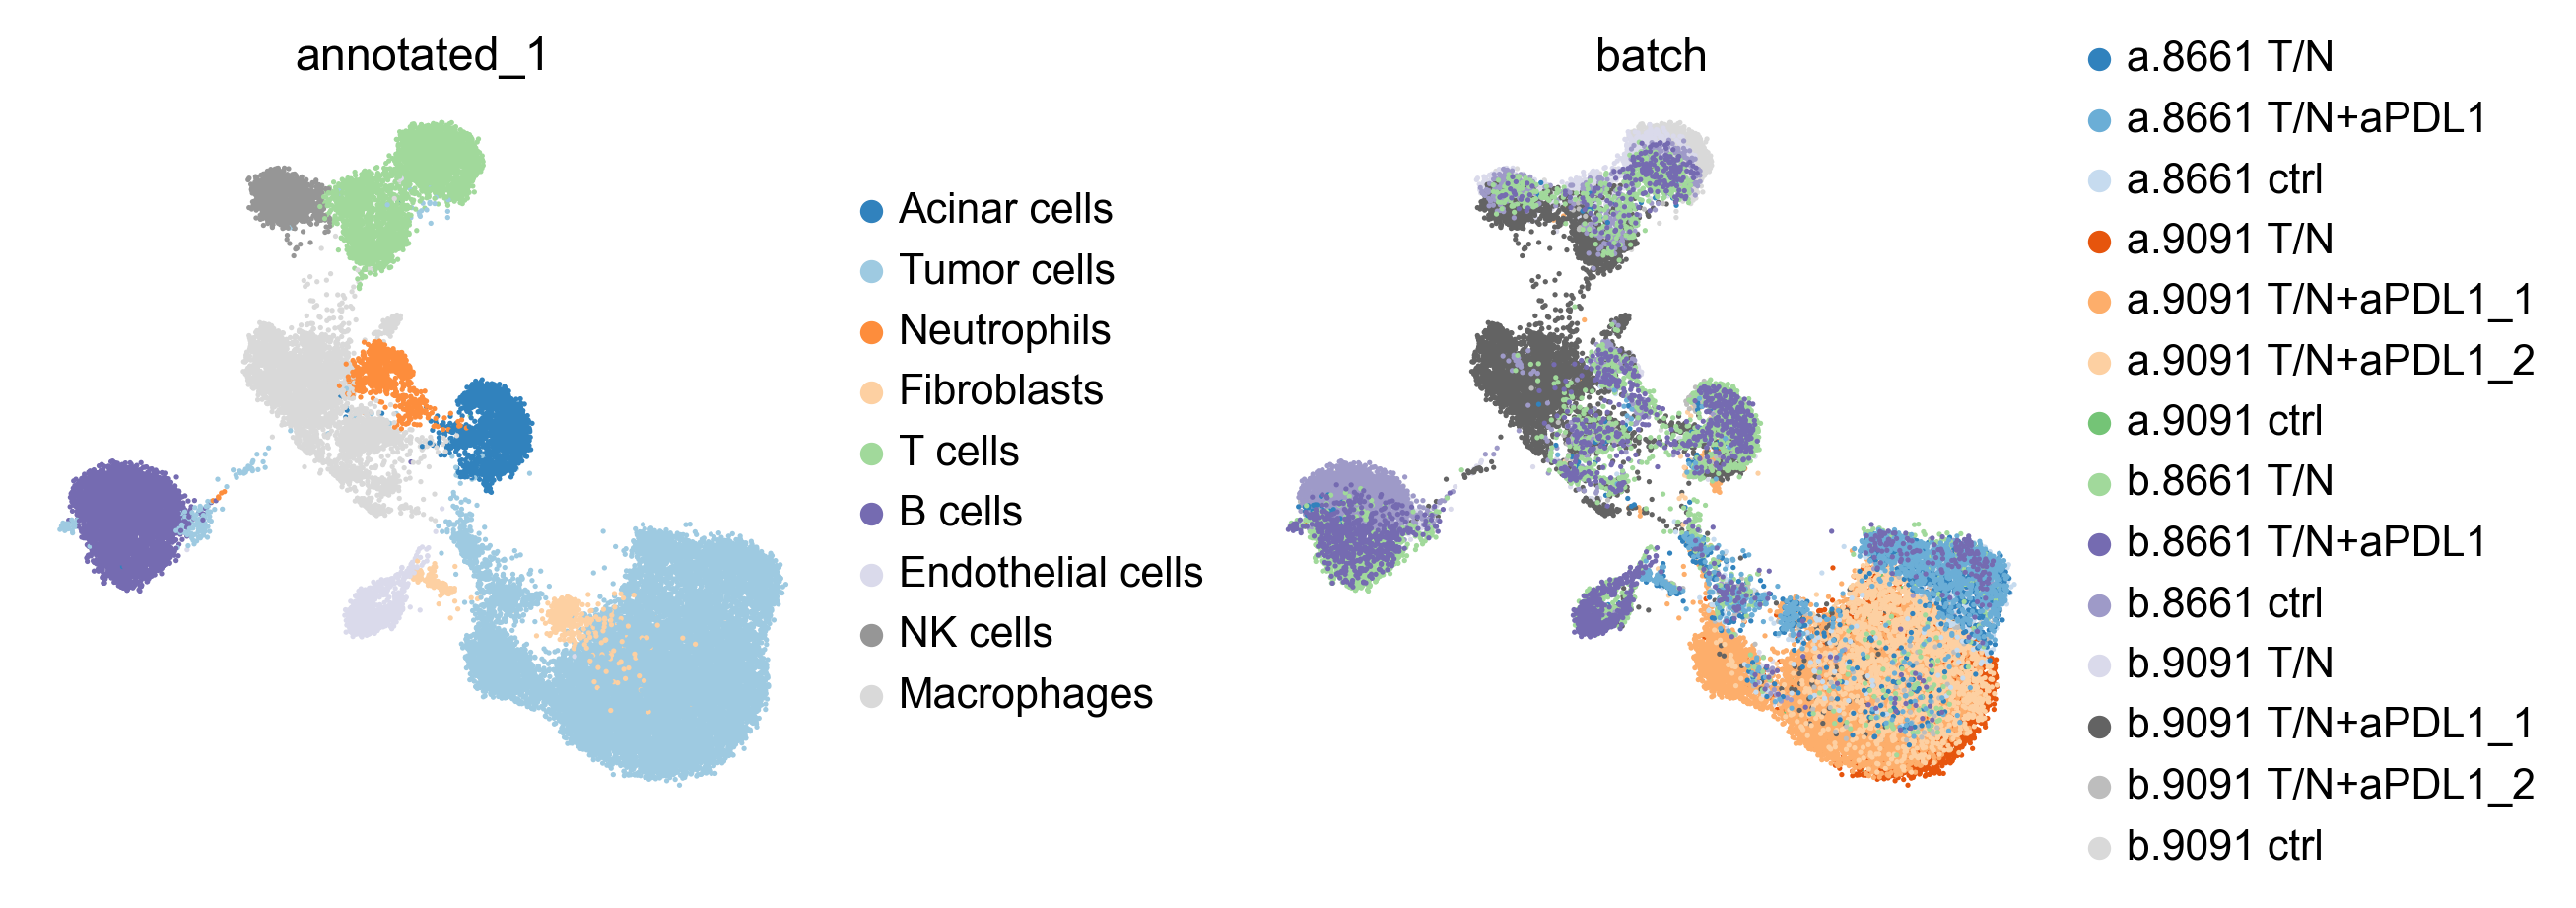

In [13]:
sc.pl.umap(adata, color=['annotated_1','batch'], size=10, wspace=0.4, palette='tab20c', frameon=False)

In [13]:
Marker_genes_dict={'Tumor cells':['Krt19','Krt18','Clu','Cdh1','Cdh2'],'Fibroblasts':['Dcn','Col1a2','Sparc'], 'MDSC':['S100a8','S100a9'],
                   'Macrophages':['Cd68','Ctss'], 'T cells':['Cd3g', 'Cd4','Cd8a'], 'B cells': ['Cd79a'], 'NK cells':['Nkg7','Klrk1'],'Endo cells':['Pecam1'],'Acinar':['Reg3b']}

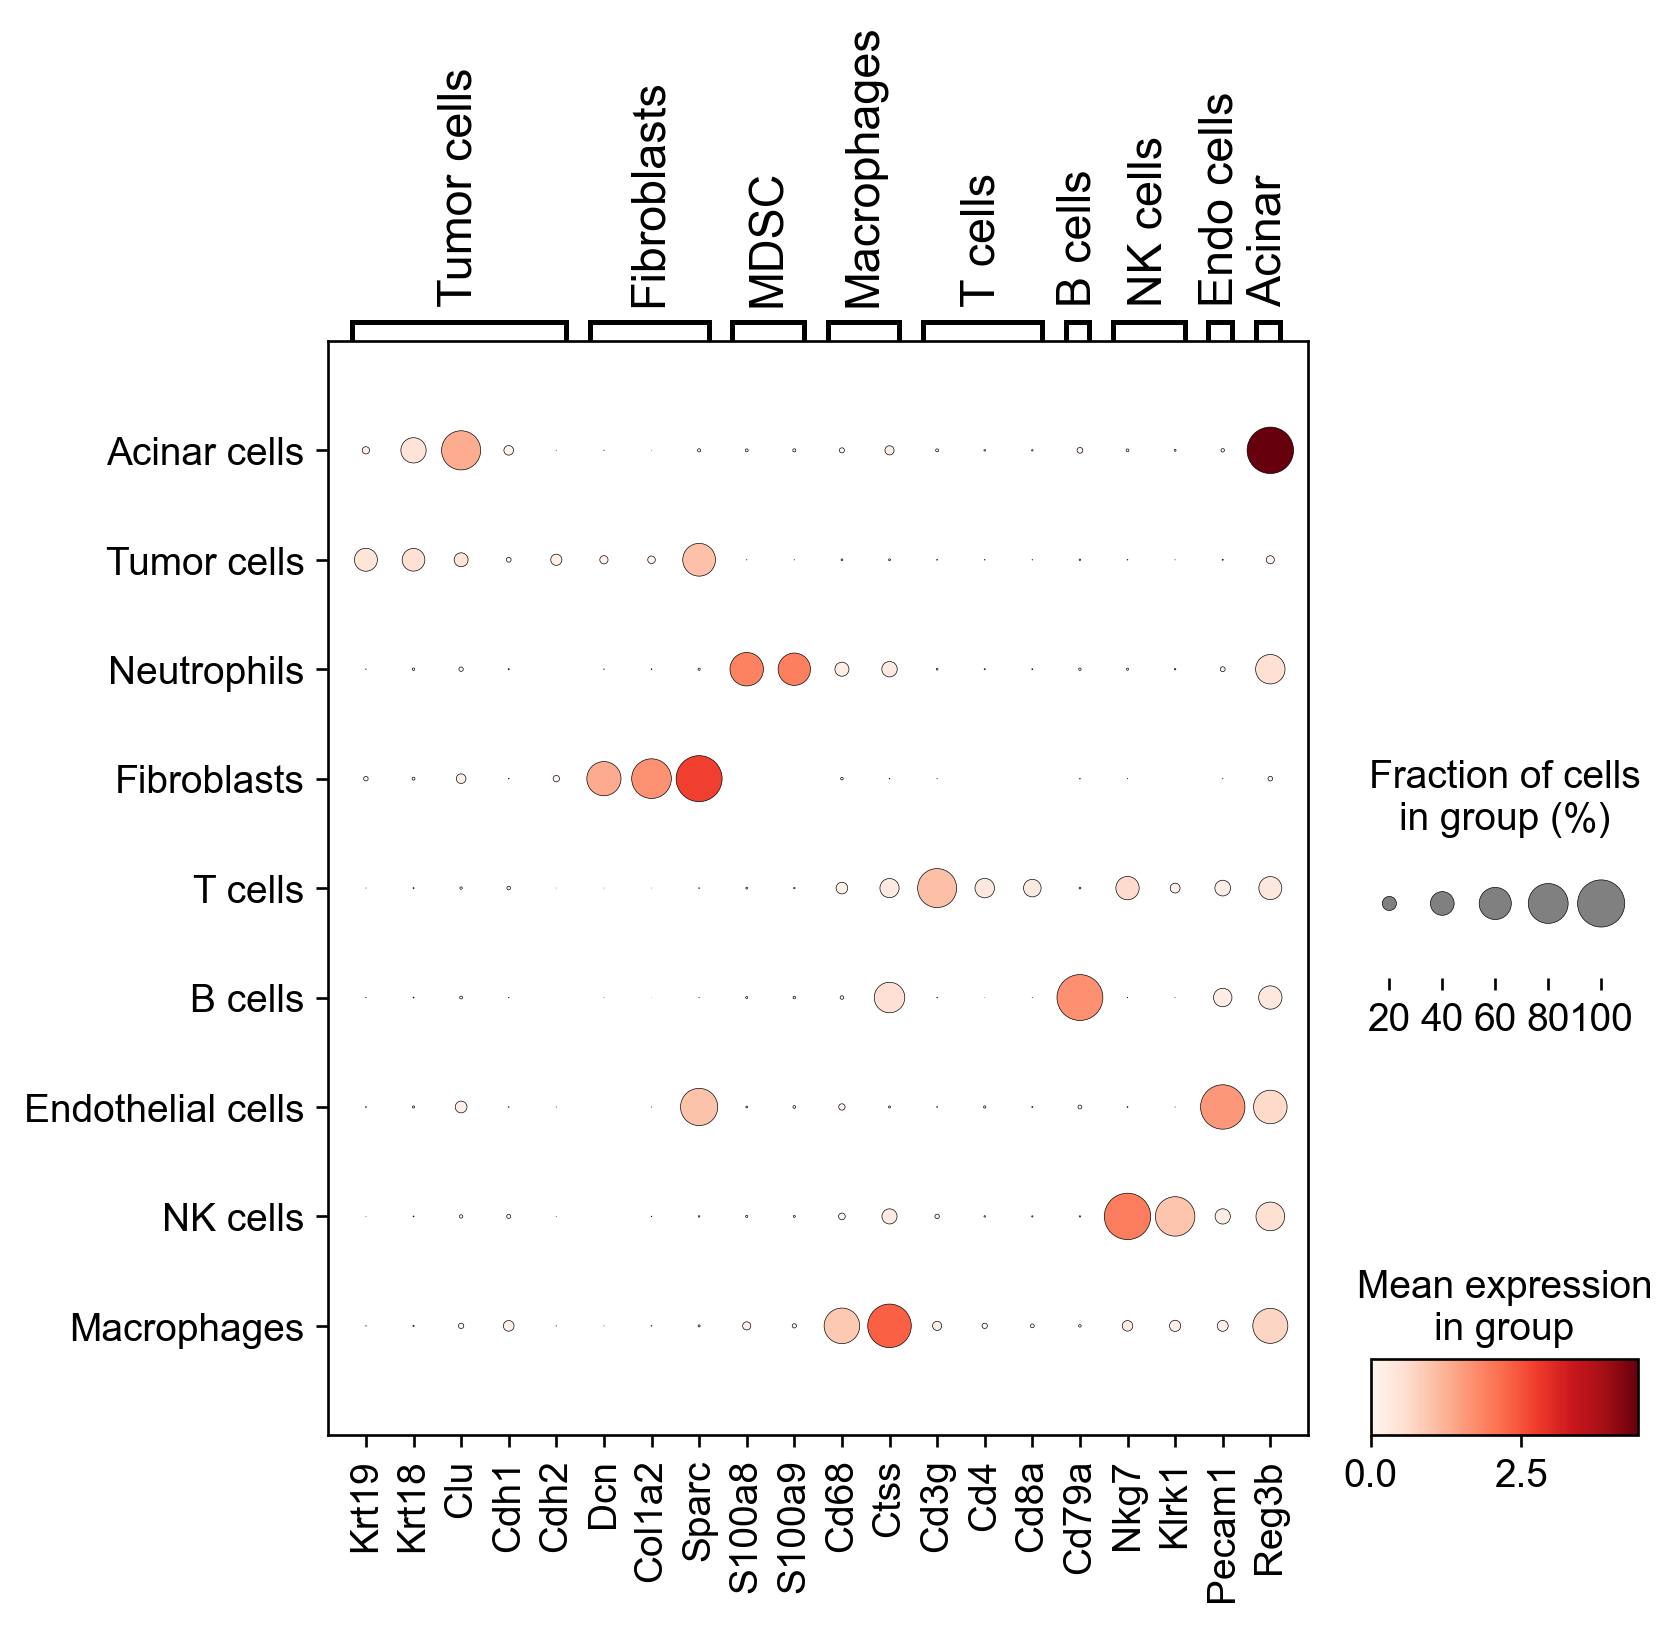

In [26]:
sc.pl.dotplot(adata, Marker_genes_dict, 'annotated_1', figsize=(7,6), smallest_dot=5, color_map='Reds',save='_markers')

In [16]:
adata.obs['annotated_1'].value_counts()

a.9091 T/N+aPDL1_1    5727
b.9091 T/N+aPDL1_1    4884
b.8661 T/N            3333
a.9091 T/N            3236
b.8661 ctrl           2710
b.8661 T/N+aPDL1      2113
a.9091 T/N+aPDL1_2    2032
b.9091 T/N            1687
b.9091 ctrl           1244
a.8661 T/N+aPDL1      1189
a.8661 T/N             910
a.8661 ctrl            653
b.9091 T/N+aPDL1_2     526
a.9091 ctrl            433
Name: batch, dtype: int64

In [8]:
adata.obs['batch_combined'] = adata.obs['batch'].cat.add_categories(['9091 T/N+aPDL1','9091 T/N','9091 ctrl',
                                                                 '8661 T/N','8661 ctrl','8661 T/N+aPDL1'])

adata.obs['batch_combined'][np.in1d(adata.obs['batch_combined'], ['a.9091 T/N+aPDL1_1','b.9091 T/N+aPDL1_1','a.9091 T/N+aPDL1_2','b.9091 T/N+aPDL1_2'])] = '9091 T/N+aPDL1'
adata.obs['batch_combined'][np.in1d(adata.obs['batch_combined'], ['a.9091 T/N','b.9091 T/N'])] = '9091 T/N'
adata.obs['batch_combined'][np.in1d(adata.obs['batch_combined'], ['a.9091 ctrl','b.9091 ctrl'])] = '9091 ctrl'
adata.obs['batch_combined'][np.in1d(adata.obs['batch_combined'], ['a.8661 T/N','b.8661 T/N'])] = '8661 T/N'
adata.obs['batch_combined'][np.in1d(adata.obs['batch_combined'], ['a.8661 ctrl','b.8661 ctrl'])] = '8661 ctrl'
adata.obs['batch_combined'][np.in1d(adata.obs['batch_combined'], ['a.8661 T/N+aPDL1','b.8661 T/N+aPDL1'])] = '8661 T/N+aPDL1'

adata.obs['batch_combined'] = adata.obs['batch_combined'].cat.remove_unused_categories()


In [9]:
adata.obs['samples'] = adata.obs['batch'].cat.add_categories(['classical','mesenchymal'])

adata.obs['samples'][np.in1d(adata.obs['samples'], ["a.8661 ctrl", "a.8661 T/N", "a.8661 T/N+aPDL1", "b.8661 ctrl", "b.8661 T/N", "b.8661 T/N+aPDL1"])] = 'classical'
adata.obs['samples'][np.in1d(adata.obs['samples'], ["a.9091 ctrl", "a.9091 T/N", "a.9091 T/N+aPDL1_1","a.9091 T/N+aPDL1_2", "b.9091 ctrl", 
                       "b.9091 T/N", "b.9091 T/N+aPDL1_1", "b.9091 T/N+aPDL1_2"])] = 'mesenchymal'



adata.obs['samples'] = adata.obs['samples'].cat.remove_unused_categories()

In [10]:
adata.obs['batch_combined_2'] = adata.obs['batch'].cat.add_categories(['a.9091 T/N+aPDL1',
                                                                       'b.9091 T/N+aPDL1',])
                                      
adata.obs['batch_combined_2'][np.in1d(adata.obs['batch_combined_2'], ['a.9091 T/N+aPDL1_1','a.9091 T/N+aPDL1_2'])] = 'a.9091 T/N+aPDL1'
adata.obs['batch_combined_2'][np.in1d(adata.obs['batch_combined_2'], ['b.9091 T/N+aPDL1_1','b.9091 T/N+aPDL1_2'])] = 'b.9091 T/N+aPDL1'


adata.obs['batch_combined_2'] = adata.obs['batch_combined_2'].cat.remove_unused_categories()



In [11]:
adata.obs['batch_combined_2'].value_counts()

a.9091 T/N+aPDL1    7759
b.9091 T/N+aPDL1    5410
b.8661 T/N          3333
a.9091 T/N          3236
b.8661 ctrl         2710
b.8661 T/N+aPDL1    2113
b.9091 T/N          1687
b.9091 ctrl         1244
a.8661 T/N+aPDL1    1189
a.8661 T/N           910
a.8661 ctrl          653
a.9091 ctrl          433
Name: batch_combined_2, dtype: int64

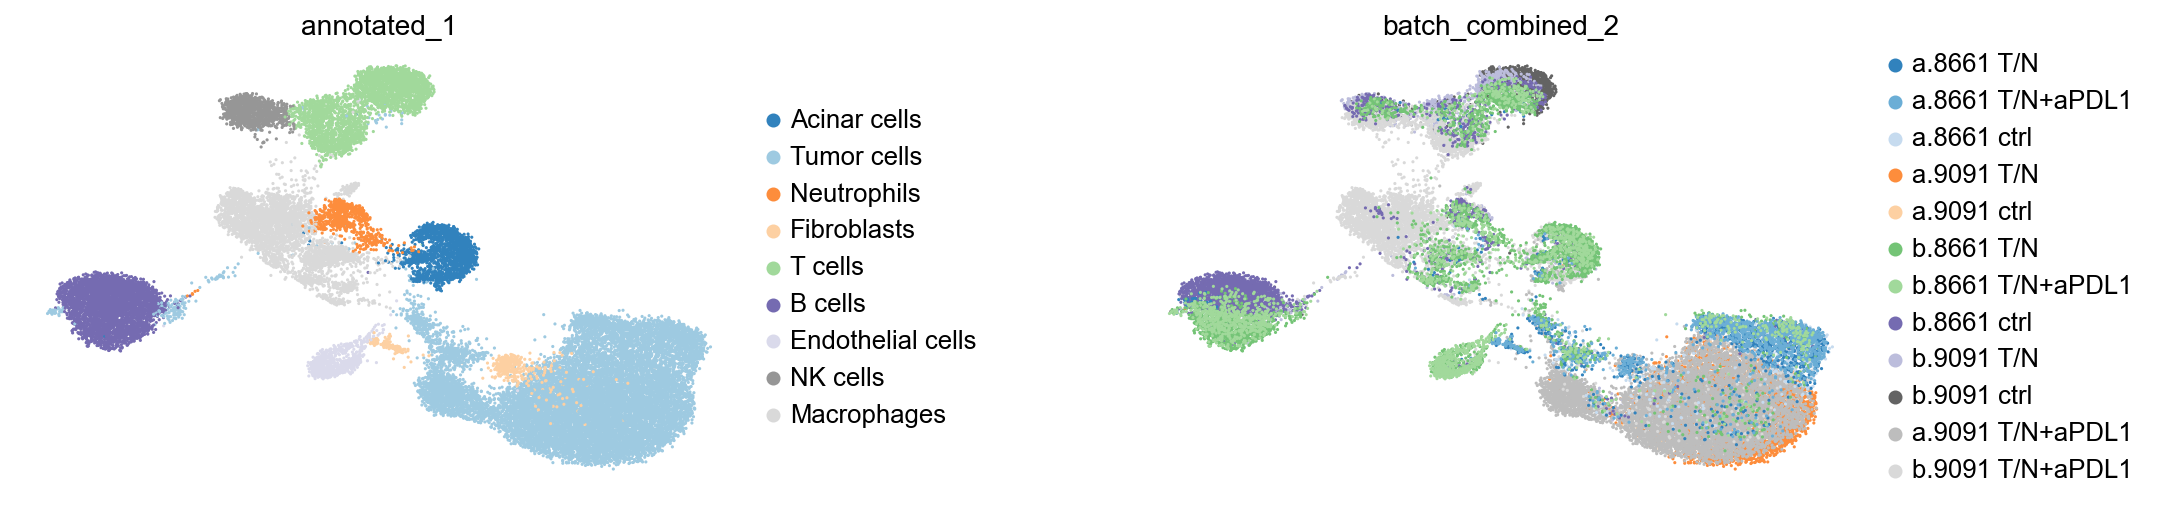

In [12]:
sc.pl.umap(adata, color=['annotated_1','batch_combined_2'], size=10, wspace=0.4, palette='tab20c', frameon=False,save='')

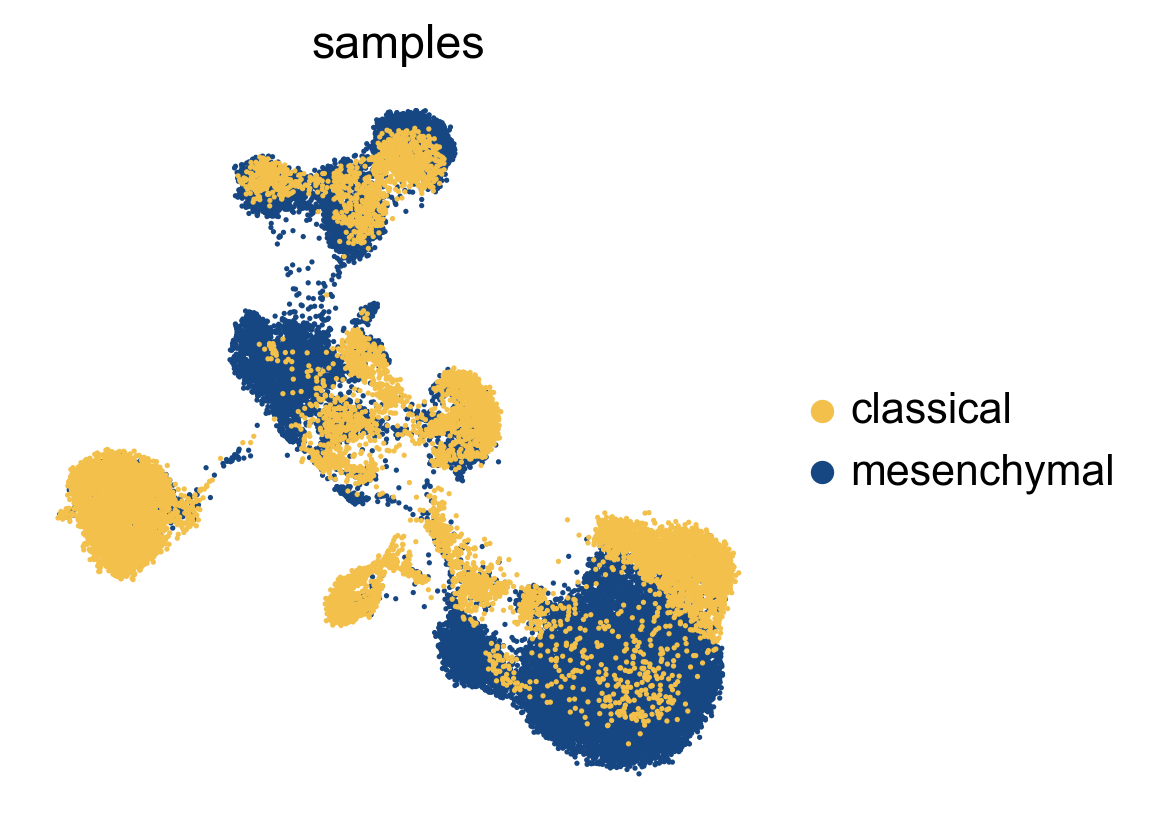

In [18]:
sc.pl.umap(adata, color=['samples'], size=10, wspace=0.4, palette=['#f2c04b','#174782'], frameon=False,save='_ClMes')

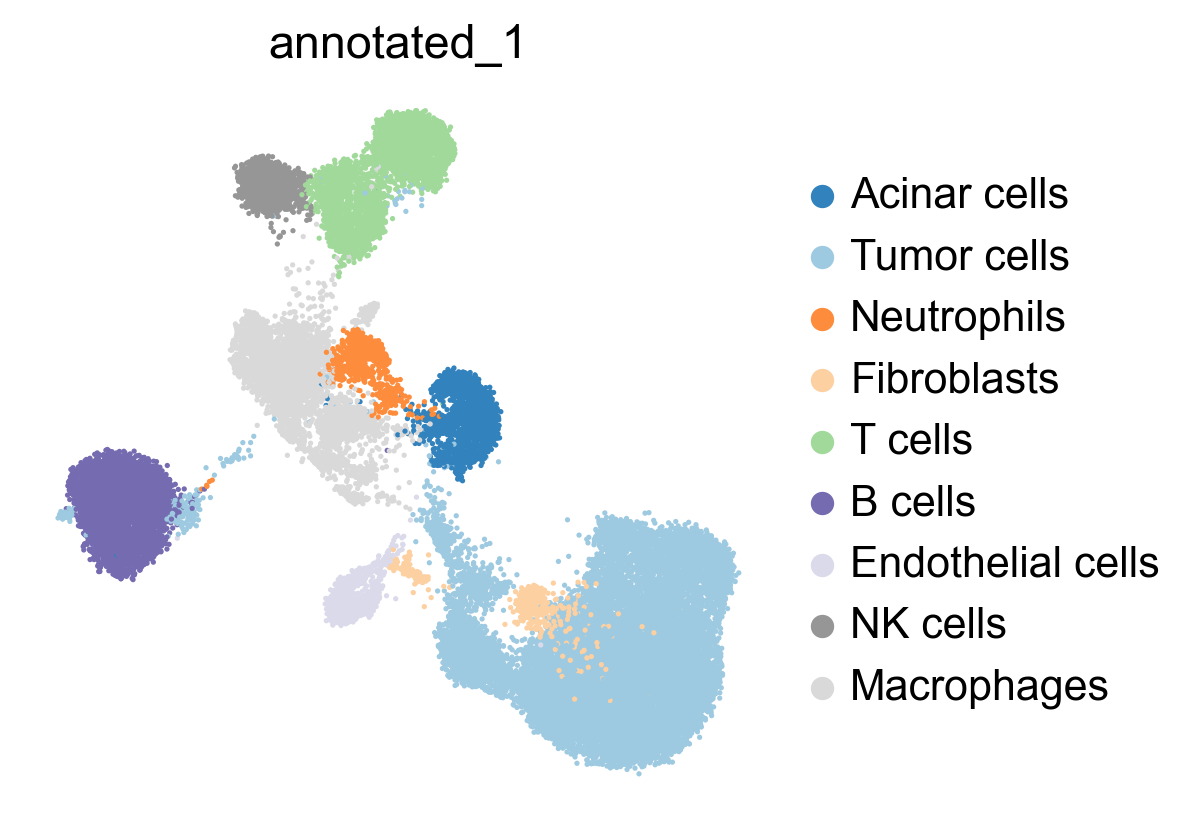

In [20]:
sc.pl.umap(adata, color=['annotated_1'], size=10, wspace=0.4, palette='tab20c', frameon=False,save='_anno')

In [21]:
adata.obs['samples2'] = adata.obs['batch'].cat.add_categories(['8661_ctrl','8661_T/N','8661_T/N+aPDL1','9091_ctrl','9091_T/N','9091_T/N+aPDL1'])

adata.obs['samples2'][np.in1d(adata.obs['samples2'], ["a.8661 ctrl", "b.8661 ctrl"])] = '8661_ctrl'
adata.obs['samples2'][np.in1d(adata.obs['samples2'], ["a.8661 T/N", "b.8661 T/N"])] = '8661_T/N'
adata.obs['samples2'][np.in1d(adata.obs['samples2'], ["a.8661 T/N+aPDL1", "b.8661 T/N+aPDL1"])] = '8661_T/N+aPDL1'
adata.obs['samples2'][np.in1d(adata.obs['samples2'], ["a.9091 ctrl", "b.9091 ctrl"])] = '9091_ctrl'
adata.obs['samples2'][np.in1d(adata.obs['samples2'], ["a.9091 T/N", "b.9091 T/N"])] = '9091_T/N'
adata.obs['samples2'][np.in1d(adata.obs['samples2'], ["a.9091 T/N+aPDL1_1","a.9091 T/N+aPDL1_2", "b.9091 T/N+aPDL1_1", "b.9091 T/N+aPDL1_2"])] = '9091_T/N+aPDL1'

adata.obs['samples2'] = adata.obs['samples2'].cat.remove_unused_categories()

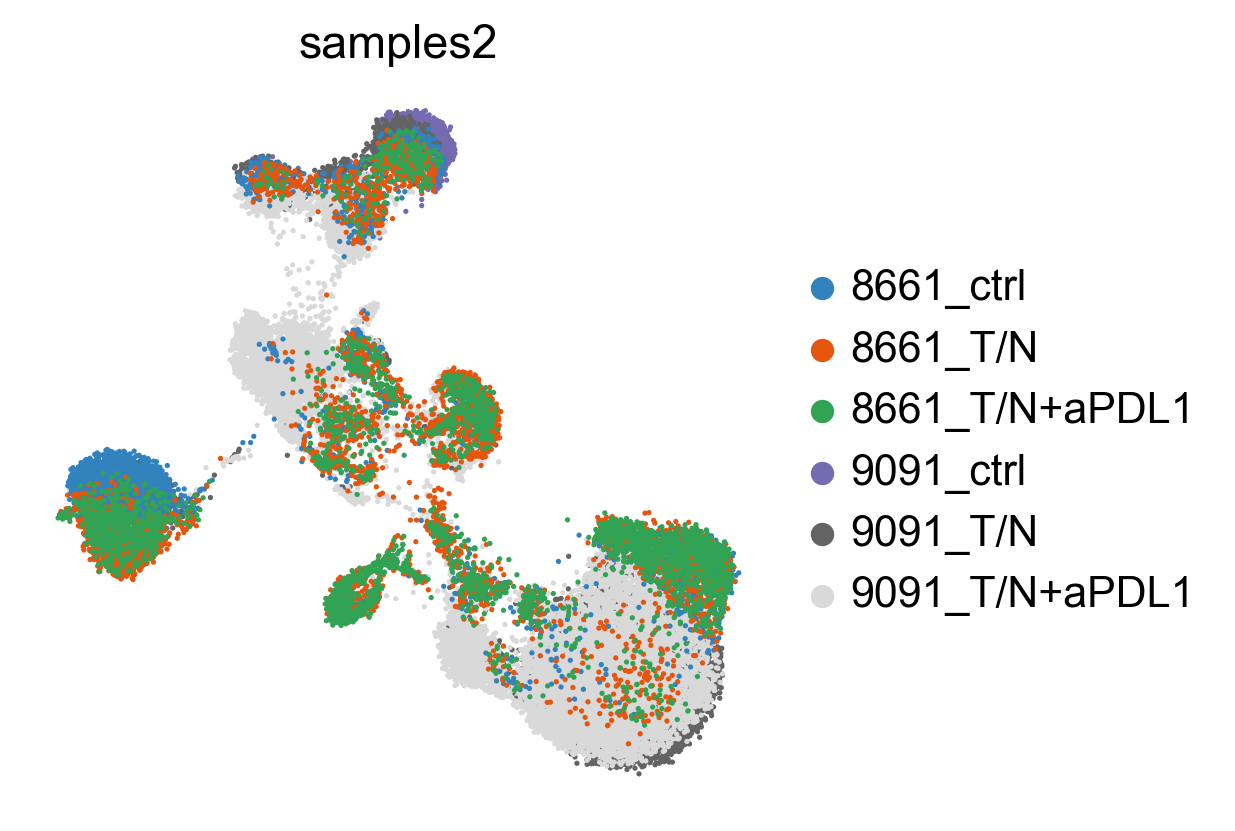

In [22]:
sc.pl.umap(adata, color=['samples2'], size=10, wspace=0.4, palette='tab20c', frameon=False,save='_treat')

Trying to set attribute `.uns` of view, copying.


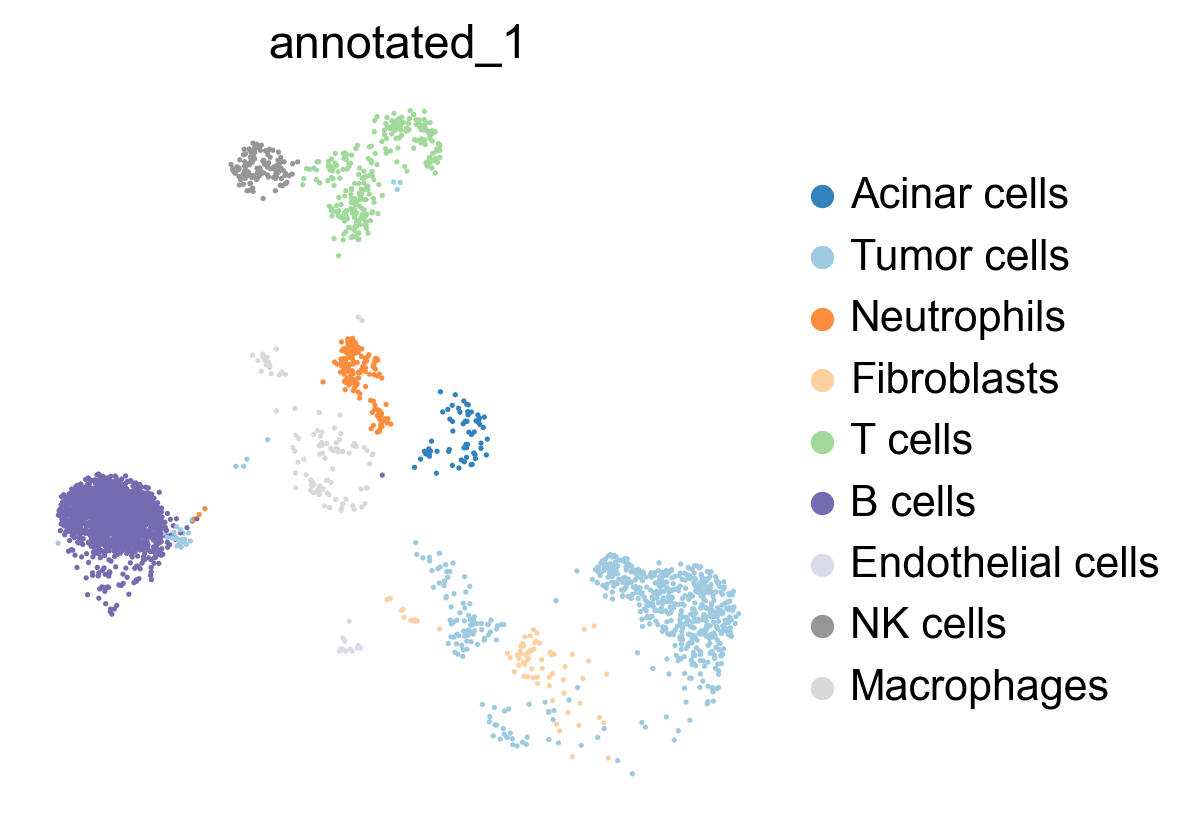

In [25]:
sc.pl.umap(adata[adata.obs['samples2']=='8661_ctrl',:],
           color=['annotated_1'], 
           size=10, wspace=0.4, palette='tab20c', frameon=False, save='_anno_8661_ctrl')

Trying to set attribute `.uns` of view, copying.


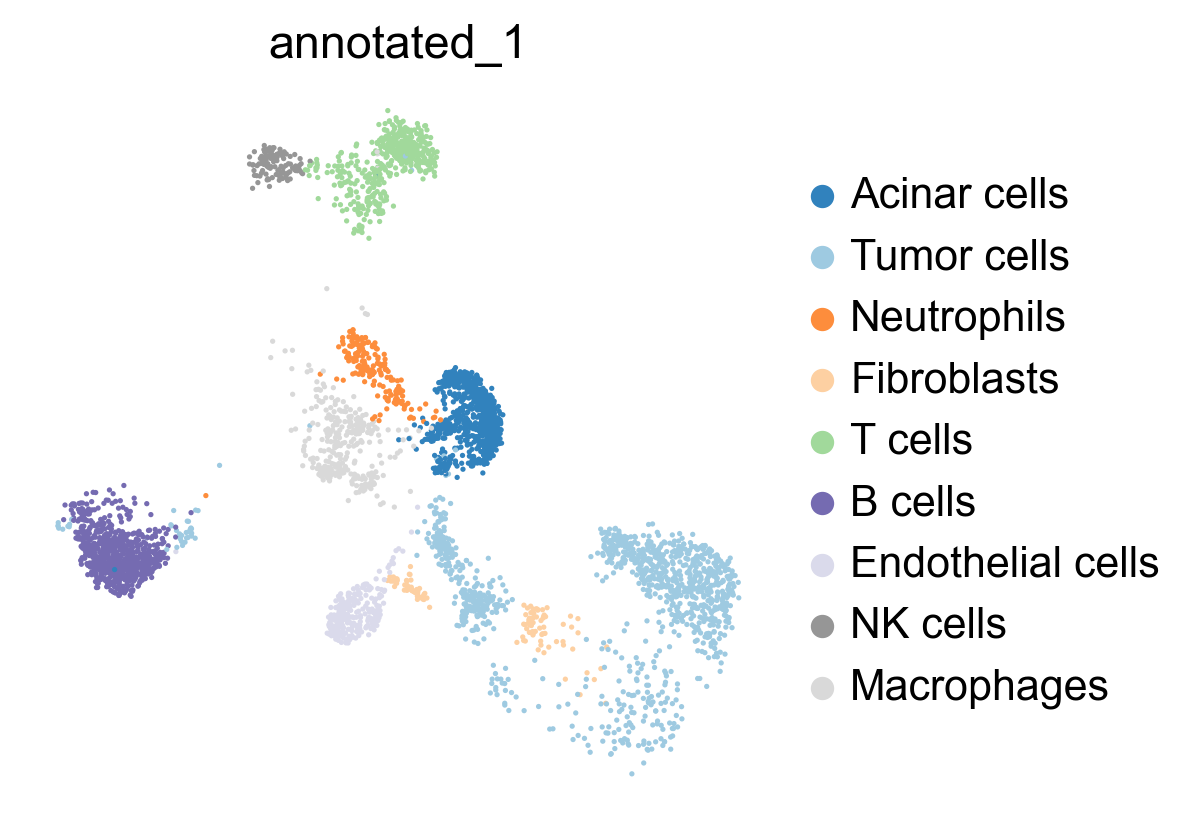

In [26]:
sc.pl.umap(adata[adata.obs['samples2']=='8661_T/N',:],
           color=['annotated_1'], 
           size=10, wspace=0.4, palette='tab20c', frameon=False, save='_anno_8661_TN')

Trying to set attribute `.uns` of view, copying.


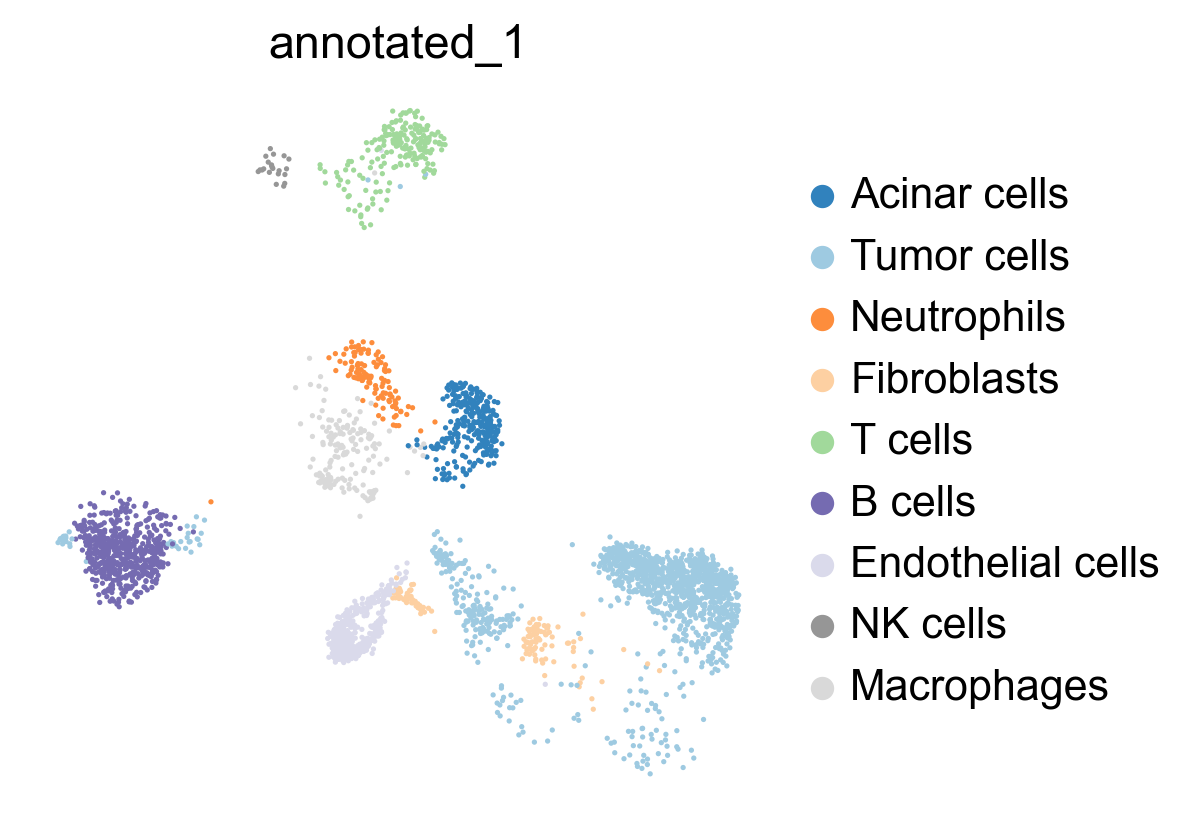

In [27]:
sc.pl.umap(adata[adata.obs['samples2']=='8661_T/N+aPDL1',:],
           color=['annotated_1'], 
           size=10, wspace=0.4, palette='tab20c', frameon=False, save='_anno_8661_TNaPDL1')

Trying to set attribute `.uns` of view, copying.


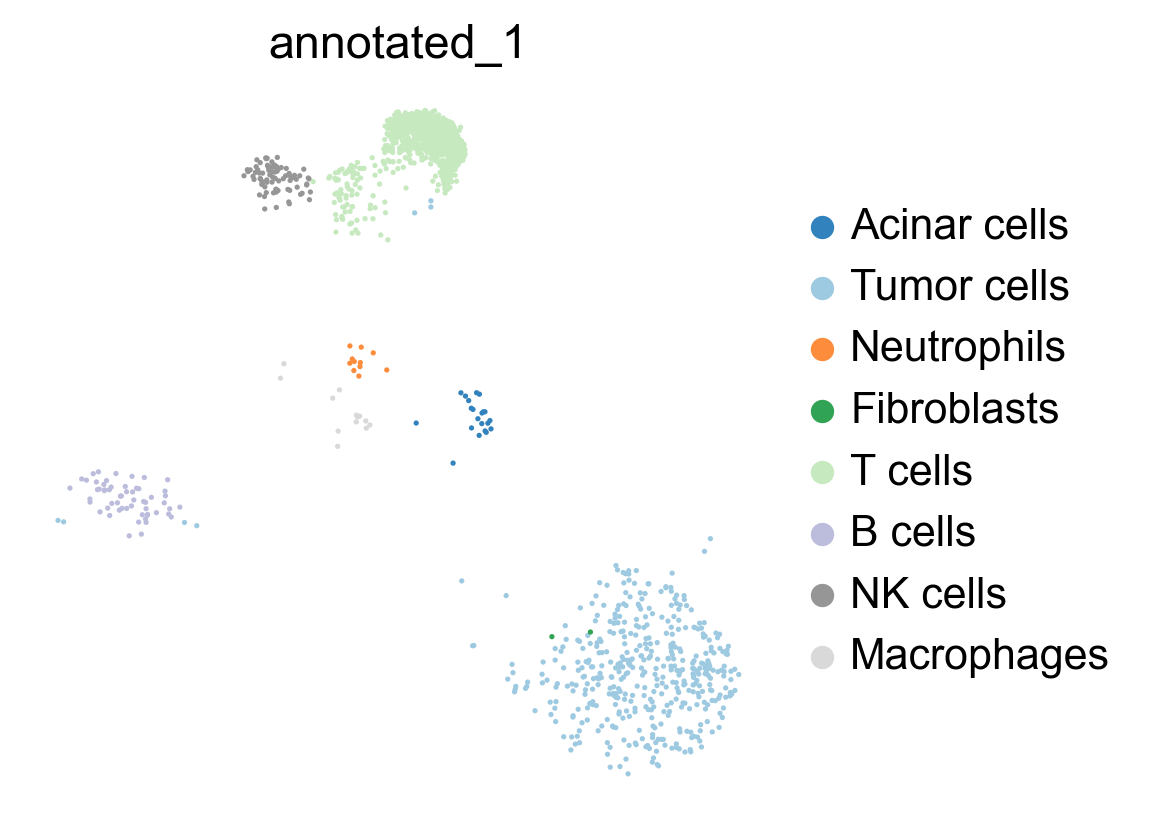

In [28]:
sc.pl.umap(adata[adata.obs['samples2']=='9091_ctrl',:],
           color=['annotated_1'], 
           size=10, wspace=0.4, palette='tab20c', frameon=False, save='_anno_9091_ctrl')

Trying to set attribute `.uns` of view, copying.


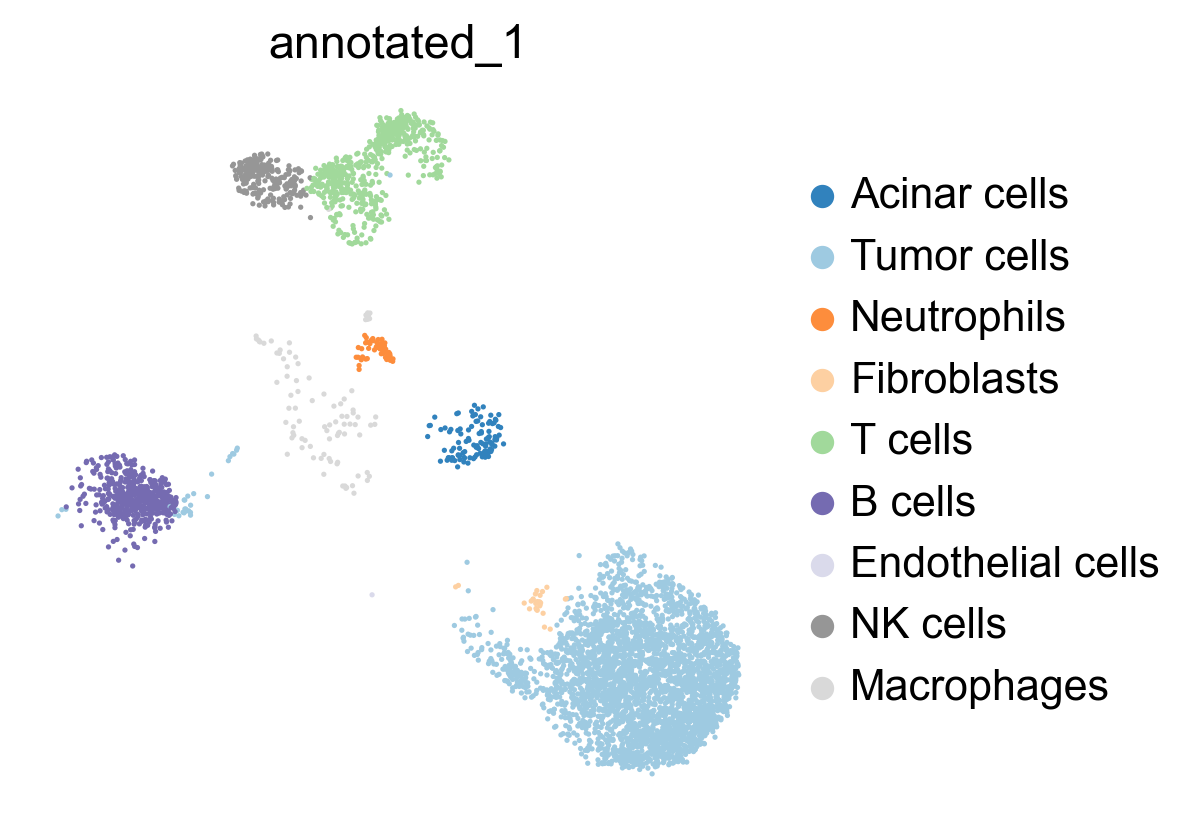

In [29]:
sc.pl.umap(adata[adata.obs['samples2']=='9091_T/N',:],
           color=['annotated_1'], 
           size=10, wspace=0.4, palette='tab20c', frameon=False, save='_anno_9091_TN')

Trying to set attribute `.uns` of view, copying.


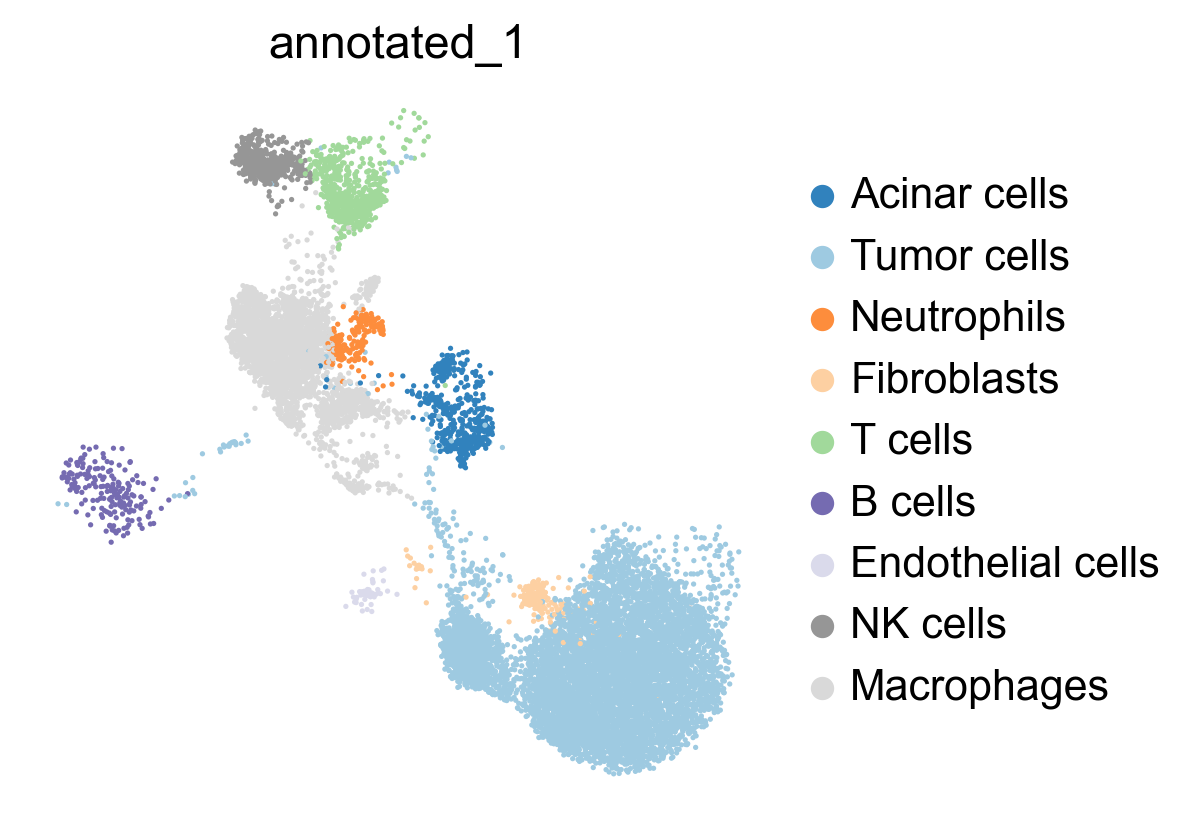

In [30]:
sc.pl.umap(adata[adata.obs['samples2']=='9091_T/N+aPDL1',:],
           color=['annotated_1'], 
           size=10, wspace=0.4, palette='tab20c', frameon=False, save='_anno_9091_TNaPDL1')

In [35]:
adata.obs['samples2'].value_counts()

9091_T/N+aPDL1    13169
9091_T/N           4923
8661_T/N           4243
8661_ctrl          3363
8661_T/N+aPDL1     3302
9091_ctrl          1677
Name: samples2, dtype: int64

In [41]:
adata[(adata.obs['batch_combined']=='8661 ctrl') & (adata.obs['annotated_1']=='Acinar cells'),:].shape[0]

64

### 8661 cell type counting - batch_combined

#### acinar cells

In [49]:
adata[(adata.obs['batch_combined']=='8661 ctrl') & (adata.obs['annotated_1']=='Acinar cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 ctrl')].shape[0]

64

In [50]:
adata[(adata.obs['batch_combined']=='8661 T/N') & (adata.obs['annotated_1']=='Acinar cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N')].shape[0]

815

In [51]:
adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1') & (adata.obs['annotated_1']=='Acinar cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1')].shape[0]

293

#### tumor cells

In [52]:
adata[(adata.obs['batch_combined']=='8661 ctrl') & (adata.obs['annotated_1']=='Tumor cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 ctrl')].shape[0]

686

In [53]:
adata[(adata.obs['batch_combined']=='8661 T/N') & (adata.obs['annotated_1']=='Tumor cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N')].shape[0]

1146

In [54]:
adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1') & (adata.obs['annotated_1']=='Tumor cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1')].shape[0]

1329

#### neutrophils

In [55]:
adata[(adata.obs['batch_combined']=='8661 ctrl') & (adata.obs['annotated_1']=='Neutrophils'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 ctrl')].shape[0]

174

In [56]:
adata[(adata.obs['batch_combined']=='8661 T/N') & (adata.obs['annotated_1']=='Neutrophils'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N')].shape[0]

188

In [57]:
adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1') & (adata.obs['annotated_1']=='Neutrophils'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1')].shape[0]

118

#### fibroblasts

In [13]:
adata[(adata.obs['batch_combined']=='8661 ctrl') & (adata.obs['annotated_1']=='Fibroblasts'),:].shape[0]/adata[(adata.obs['batch_combined']=='8661 ctrl')].shape[0]

0.022598870056497175

In [14]:
adata[(adata.obs['batch_combined']=='8661 T/N') & (adata.obs['annotated_1']=='Fibroblasts'),:].shape[0]/adata[(adata.obs['batch_combined']=='8661 T/N')].shape[0]

0.02686778222955456

In [15]:
adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1') & (adata.obs['annotated_1']=='Fibroblasts'),:].shape[0]/adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1')].shape[0]

0.04058146577831617

#### T cells

In [61]:
adata[(adata.obs['batch_combined']=='8661 ctrl') & (adata.obs['annotated_1']=='T cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 ctrl')].shape[0]

261

In [62]:
adata[(adata.obs['batch_combined']=='8661 T/N') & (adata.obs['annotated_1']=='T cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N')].shape[0]

500

In [63]:
adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1') & (adata.obs['annotated_1']=='T cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1')].shape[0]

202

#### B cells

In [64]:
adata[(adata.obs['batch_combined']=='8661 ctrl') & (adata.obs['annotated_1']=='B cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 ctrl')].shape[0]

1862

In [65]:
adata[(adata.obs['batch_combined']=='8661 T/N') & (adata.obs['annotated_1']=='B cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N')].shape[0]

775

In [66]:
adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1') & (adata.obs['annotated_1']=='B cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1')].shape[0]

587

#### endothelial cells

In [67]:
adata[(adata.obs['batch_combined']=='8661 ctrl') & (adata.obs['annotated_1']=='Endothelial cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 ctrl')].shape[0]

15

In [68]:
adata[(adata.obs['batch_combined']=='8661 T/N') & (adata.obs['annotated_1']=='Endothelial cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N')].shape[0]

274

In [69]:
adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1') & (adata.obs['annotated_1']=='Endothelial cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1')].shape[0]

457

#### NK cells

In [70]:
adata[(adata.obs['batch_combined']=='8661 ctrl') & (adata.obs['annotated_1']=='NK cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 ctrl')].shape[0]

125

In [71]:
adata[(adata.obs['batch_combined']=='8661 T/N') & (adata.obs['annotated_1']=='NK cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N')].shape[0]

115

In [72]:
adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1') & (adata.obs['annotated_1']=='NK cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1')].shape[0]

22

#### Macrophages

In [73]:
adata[(adata.obs['batch_combined']=='8661 ctrl') & (adata.obs['annotated_1']=='Macrophages'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 ctrl')].shape[0]

100

In [74]:
adata[(adata.obs['batch_combined']=='8661 T/N') & (adata.obs['annotated_1']=='Macrophages'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N')].shape[0]

316

In [75]:
adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1') & (adata.obs['annotated_1']=='Macrophages'),:].shape[0]#/adata[(adata.obs['batch_combined']=='8661 T/N+aPDL1')].shape[0]

160

### 9091 cell type counting - batch_combined

#### acinar cells

In [76]:
adata[(adata.obs['batch_combined']=='9091 ctrl') & (adata.obs['annotated_1']=='Acinar cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 ctrl')].shape[0]

21

In [77]:
adata[(adata.obs['batch_combined']=='9091 T/N') & (adata.obs['annotated_1']=='Acinar cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N')].shape[0]

106

In [78]:
adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1') & (adata.obs['annotated_1']=='Acinar cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1')].shape[0]

443

#### tumor cells

In [79]:
adata[(adata.obs['batch_combined']=='9091 ctrl') & (adata.obs['annotated_1']=='Tumor cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 ctrl')].shape[0]

440

In [80]:
adata[(adata.obs['batch_combined']=='9091 T/N') & (adata.obs['annotated_1']=='Tumor cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N')].shape[0]

3313

In [81]:
adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1') & (adata.obs['annotated_1']=='Tumor cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1')].shape[0]

7874

#### neutrophils

In [82]:
adata[(adata.obs['batch_combined']=='9091 ctrl') & (adata.obs['annotated_1']=='Neutrophils'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 ctrl')].shape[0]

11

In [83]:
adata[(adata.obs['batch_combined']=='9091 T/N') & (adata.obs['annotated_1']=='Neutrophils'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N')].shape[0]

55

In [84]:
adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1') & (adata.obs['annotated_1']=='Neutrophils'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1')].shape[0]

174

#### fibroblasts

In [85]:
adata[(adata.obs['batch_combined']=='9091 ctrl') & (adata.obs['annotated_1']=='Fibroblasts'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 ctrl')].shape[0]

2

In [86]:
adata[(adata.obs['batch_combined']=='9091 T/N') & (adata.obs['annotated_1']=='Fibroblasts'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N')].shape[0]

27

In [87]:
adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1') & (adata.obs['annotated_1']=='Fibroblasts'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1')].shape[0]

178

#### T cells

In [88]:
adata[(adata.obs['batch_combined']=='9091 ctrl') & (adata.obs['annotated_1']=='T cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 ctrl')].shape[0]

1053

In [89]:
adata[(adata.obs['batch_combined']=='9091 T/N') & (adata.obs['annotated_1']=='T cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N')].shape[0]

580

In [90]:
adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1') & (adata.obs['annotated_1']=='T cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1')].shape[0]

664

#### B cells

In [91]:
adata[(adata.obs['batch_combined']=='9091 ctrl') & (adata.obs['annotated_1']=='B cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 ctrl')].shape[0]

57

In [92]:
adata[(adata.obs['batch_combined']=='9091 T/N') & (adata.obs['annotated_1']=='B cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N')].shape[0]

504

In [93]:
adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1') & (adata.obs['annotated_1']=='B cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1')].shape[0]

188

#### endothelial cells

In [94]:
adata[(adata.obs['batch_combined']=='9091 ctrl') & (adata.obs['annotated_1']=='Endothelial cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 ctrl')].shape[0]

0

In [95]:
adata[(adata.obs['batch_combined']=='9091 T/N') & (adata.obs['annotated_1']=='Endothelial cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N')].shape[0]

1

In [96]:
adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1') & (adata.obs['annotated_1']=='Endothelial cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1')].shape[0]

45

#### NK cells

In [97]:
adata[(adata.obs['batch_combined']=='9091 ctrl') & (adata.obs['annotated_1']=='NK cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 ctrl')].shape[0]

80

In [98]:
adata[(adata.obs['batch_combined']=='9091 T/N') & (adata.obs['annotated_1']=='NK cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N')].shape[0]

247

In [99]:
adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1') & (adata.obs['annotated_1']=='NK cells'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1')].shape[0]

507

#### Macrophages

In [100]:
adata[(adata.obs['batch_combined']=='9091 ctrl') & (adata.obs['annotated_1']=='Macrophages'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 ctrl')].shape[0]

13

In [101]:
adata[(adata.obs['batch_combined']=='9091 T/N') & (adata.obs['annotated_1']=='Macrophages'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N')].shape[0]

90

In [102]:
adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1') & (adata.obs['annotated_1']=='Macrophages'),:].shape[0]#/adata[(adata.obs['batch_combined']=='9091 T/N+aPDL1')].shape[0]

3096